Overview of the code:
1.   Explore the Example Data of Cats and Dogs
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Visualize learned representation
4.   Evaluate the Training and Validation accuracy

Data(a .zip of 2,000 JPG pictures of cats and dogs), extracted locally in `/tmp`. A subset of the full dataset["Dogs vs. Cats" dataset] (https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. 

In [0]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories , which in turn each contain `cats` and `dogs` subdirectories.

Used ImageGenerator to read images from subdirectories, and automatically label them from the name of that subdirectory. 

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [0]:
#check 10 filenames
train_cat_fnames = os.listdir(train_cats_dir )
train_dog_fnames = os.listdir(train_dogs_dir )
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

#count total train and validation images
print('total training cat images :',len(os.listdir(train_cats_dir)))
print('total training dog images :',len(os.listdir(train_dogs_dir)))
print('total validation cat images :',len(os.listdir(validation_cats_dir)))
print('total validation dog images :',len(os.listdir(validation_dogs_dir)))

In [0]:
#Configure the matplot parameters to view pictures
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

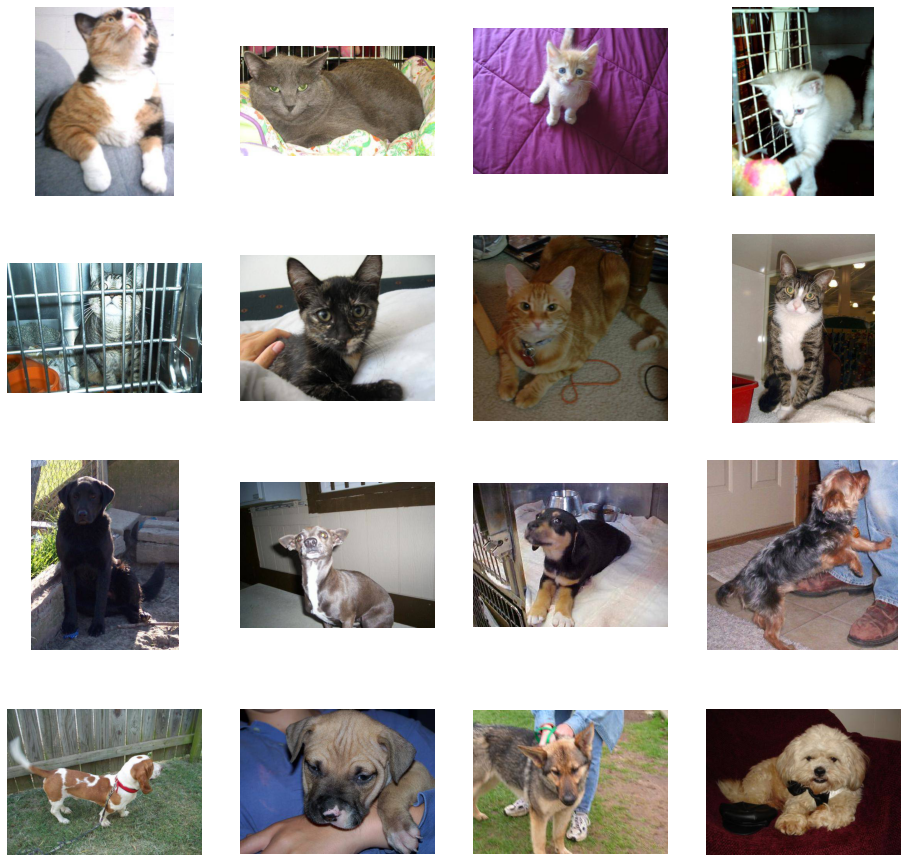

In [9]:
# Display a batch of 8 cat and 8 dog pictures
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [10]:
#Building a Small Model from Scratch
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Steps at this position are: Read pictures from source folders 
convert them to `float32` tensors
and feed them to NN.  

Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

We will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training the model
Train on all 2,000 images available and validate on all 1,000 test images. 

Check 4 values per epoch:
 Loss,
 Accuracy,
 Validation Loss, 
 Validation Accuracy. 

In [13]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 10s - loss: 0.7435 - accuracy: 0.5635 - val_loss: 0.6559 - val_accuracy: 0.5750
Epoch 2/15
100/100 - 10s - loss: 0.6281 - accuracy: 0.6690 - val_loss: 0.5947 - val_accuracy: 0.6870
Epoch 3/15
100/100 - 10s - loss: 0.5487 - accuracy: 0.7220 - val_loss: 0.6076 - val_accuracy: 0.6750
Epoch 4/15
100/100 - 10s - loss: 0.4567 - accuracy: 0.7870 - val_loss: 0.5739 - val_accuracy: 0.7120
Epoch 5/15
100/100 - 10s - loss: 0.3697 - accuracy: 0.8350 - val_loss: 0.8154 - val_accuracy: 0.6480
Epoch 6/15
100/100 - 10s - loss: 0.2897 - accuracy: 0.8750 - val_loss: 0.7927 - val_accuracy: 0.6990
Epoch 7/15
100/100 - 10s - loss: 0.2257 - accuracy: 0.9160 - val_loss: 0.8892 - val_accuracy: 0.7140
Epoch 8/15
100/100 - 10s - loss: 0.1544 - accuracy: 0.9445 - val_loss: 1.0011 - val_accuracy: 0.7060
Epoch 9/15
100/100 - 10s - loss: 0.1288 - accuracy: 0.9585 - val_loss: 1.1688 - val_accuracy: 0.7030
Epoch 10/15
100/100 - 10s - loss: 0.0913 - accuracy: 0.9685 - val_loss: 1.1867 - val_accura

###Running the Model

Running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a dog or a cat.

In [0]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")
 

### Visualizing Intermediate Representations

To visualize the kind of features our convnet has learned, we can visualize how an input gets transformed as it goes through the convnet.

We select, a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


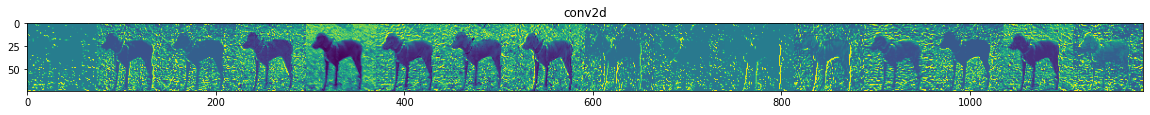

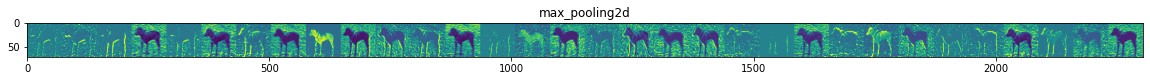

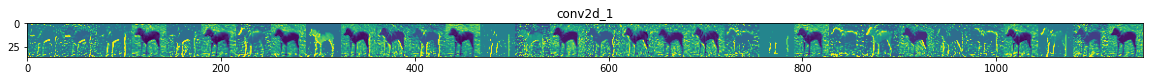

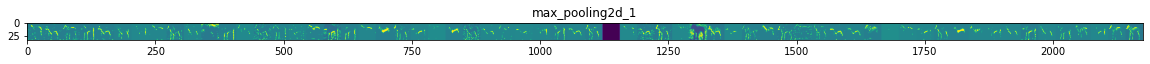

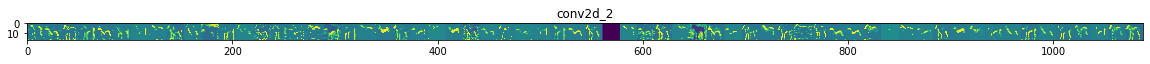

In [15]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model to  take an image as input  
# Output intermediate representations for all layers in the previous model after
# the first
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)              # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)      # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Run image through the network, obtaining all intermediate representations 
# for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    # Do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

The features goes from raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.

Text(0.5, 1.0, 'Training and validation loss')

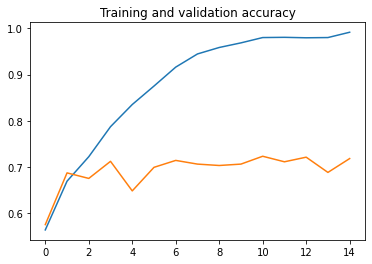

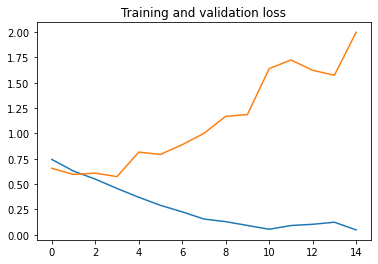

In [16]:
#Evaluating Accuracy and Loss for the Model# Retrieve a list of list results on training and test data
# sets for each training epoch
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


# Plot training and validation loss per epoch
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )